In [2]:
from itertools import product
from time import sleep
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import seaborn as sns

In [3]:
q = 4
RANDOM_SEED = 42424
WIDTH = 15
J_c = 1  # ?
h = 1

In [4]:
# Python type hinting; the code works well without this
Interaction = Callable[[int, int], float]

In [5]:
def generate_correlated_field(rg: RandomState, correlation: float=0.3):
    field = np.array(rg.randint(q, size=[WIDTH, WIDTH]), dtype=np.int8)

    for i in range(field.shape[0]):
        for j in range(field.shape[1]):
            if i > 0 and j > 0 and rg.uniform() < correlation:
                if rg.uniform() < 0.5:
                    field[i,j] = field[i-1,j]
                else:
                    field[i,j] = field[i,j-1]
    return field

In [6]:
rg = RandomState(RANDOM_SEED)
field = generate_correlated_field(rg, 0.5)

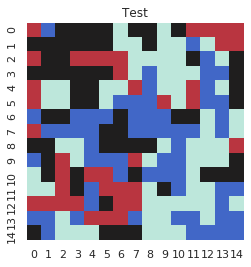

In [7]:
%matplotlib inline
def show_field(field: np.ndarray, title: Optional[str]=None) -> None:
    sns.set()
    ax = sns.heatmap(field, center=q/2, square=True, cbar=False)
    if title:
        ax.set_title(title)
    ax.get_figure().savefig('field.png')

show_field(field, 'Test')

In [8]:
def kronecker(spin_1: int, spin_2: int) -> float:
    return float(spin_1 == spin_2)

def energy(field: np.ndarray, interaction: Interaction) -> float:
    energy = 0
    for i, j in product(range(WIDTH - 1), range(WIDTH)):
        energy += interaction(field[i, j], field[i + 1, j])

    for i, j in product(range(WIDTH), range(WIDTH - 1)):  # dim
        energy += interaction(field[i, j], field[i, j + 1])
    
    return 2 * J_c * energy + h * field.sum()
    
energy(field, kronecker)

687.0

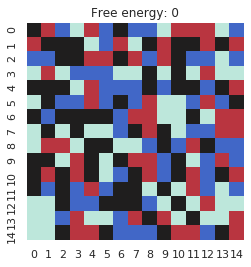

In [10]:
def calculate_interaction_of_one_spin(field: np.ndarray, x: int, y: int, interaction: Interaction) -> float:
    # factor 2 ?!
    energy = 0
    if x > 0:  # dim!!
        energy += interaction(field[x-1,y], field[x,y])
    if x < WIDTH - 1:
        energy += interaction(field[x,y], field[x+1,y])
    if y > 0:
        energy += interaction(field[x,y-1], field[x,y])
    if y < WIDTH - 1:
        energy += interaction(field[x,y], field[x,y+1])
    return 2 * J_c * energy

def calculate_energy_difference(field: np.ndarray, x: int, y: int, new_spin: int, interaction: Interaction) -> (float, np.ndarray):
    # positive return value: update would imply energetically less favorable state
    current_energy = calculate_interaction_of_one_spin(field, x, y, interaction)
    field_updated = field.copy()  # Avoid side effects of function by copying
    field_updated[x,y] = new_spin
    updated_energy = calculate_interaction_of_one_spin(field_updated, x, y, interaction)
    energy_difference = updated_energy - current_energy + h * (field_updated[x,y] - field[x,y])
    return (updated_energy - current_energy, field_updated)

def update_metropolis(field: np.ndarray, free_energy: float, interaction: Interaction, random_state: RandomState) -> (np.ndarray, float):
    random_x, random_y = random_state.randint(WIDTH, size=[2])  # dim
    random_spin = random_state.randint(q)
    energy_difference, field_updated = calculate_energy_difference(field, random_x, random_y, random_spin, interaction)
    if energy_difference < 0 or random_state.uniform():
        # free_energy_updated = free_energy - energy_difference
        return field_updated, free_energy
    else:
        return field, free_energy

free_energy = 0
rg = RandomState(RANDOM_SEED)
field = np.array(rg.randint(q, size=[WIDTH, WIDTH]), dtype=np.int8)
for i in range(100):
    for _ in range(10):
        field, free_energy = update_metropolis(field, free_energy, kronecker, rg)
    show_field(field, f'Free energy: {free_energy}')
    sleep(0.2)

Possible future extension:
* Boundary conditions at will
* Higher number of dimensions
